In [2]:
import deepchem as dc
import pandas as pd
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,KFold

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [3]:
data = pd.read_csv('../../data/GABAA.csv',encoding='gb18030')

# Feature extraction & Data splitting

In [4]:
featurizer = dc.feat.CircularFingerprint(size=1024,radius=4)
features = featurizer.featurize(data['smiles'])
#dataset = dc.data.NumpyDataset(features,data['class'])

In [5]:
from sklearn.feature_selection import VarianceThreshold


vt = VarianceThreshold(threshold = (.98 * (1 - .98)))


X_new = vt.fit_transform(features)
dataset = dc.data.NumpyDataset(X_new,data['class'])

In [6]:
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=300)

# GridSearchCV

In [11]:
scoring = {
         'AUC':make_scorer(roc_auc_score, needs_proba=True),
          'ACC':make_scorer(accuracy_score),
           'PRE':make_scorer(precision_score),
           'REC':make_scorer(recall_score),
}

param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100], 
              'kernel': ['rbf'],
             'gamma':[0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.8, 0.9, 1]
             }
    
svm_classifier = SVC(probability=True)


gs = GridSearchCV(
                    svm_classifier,
                   param_grid,
                 scoring = scoring,
                  cv = KFold(n_splits=5, shuffle=True, random_state=300),
                 n_jobs = -1,
               refit = 'AUC',
               return_train_score = True)

gs_fit = gs.fit(train_dataset.X, train_dataset.y.ravel())

In [12]:
val_AUC = gs.best_score_
val_ACC = gs.cv_results_['mean_test_ACC'][gs.best_index_]
val_PRE = gs.cv_results_['mean_test_PRE'][gs.best_index_]
val_REC = gs.cv_results_['mean_test_REC'][gs.best_index_]

# GridSearchCV_Result

In [13]:
print('Best parameters: ', gs.best_params_)
print('Best score (AUC): ', gs.best_score_)
print('ACC: ',gs.cv_results_['mean_test_ACC'][gs.best_index_])
print('PRE: ',gs.cv_results_['mean_test_PRE'][gs.best_index_])
print('REC: ',gs.cv_results_['mean_test_REC'][gs.best_index_])

Best parameters:  {'C': 2.5, 'gamma': 0.01, 'kernel': 'rbf'}
Best score (AUC):  0.9283415525478598
ACC:  0.8692307692307694
PRE:  0.8585539455528851
REC:  0.8839132442865612


In [14]:
model = gs_fit.best_estimator_
model

SVC(C=2.5, gamma=0.01, probability=True)

# Evaluate model

In [15]:
y_test_pred_proba = model.predict_proba(test_dataset.X)
y_test_pred = model.predict(test_dataset.X)

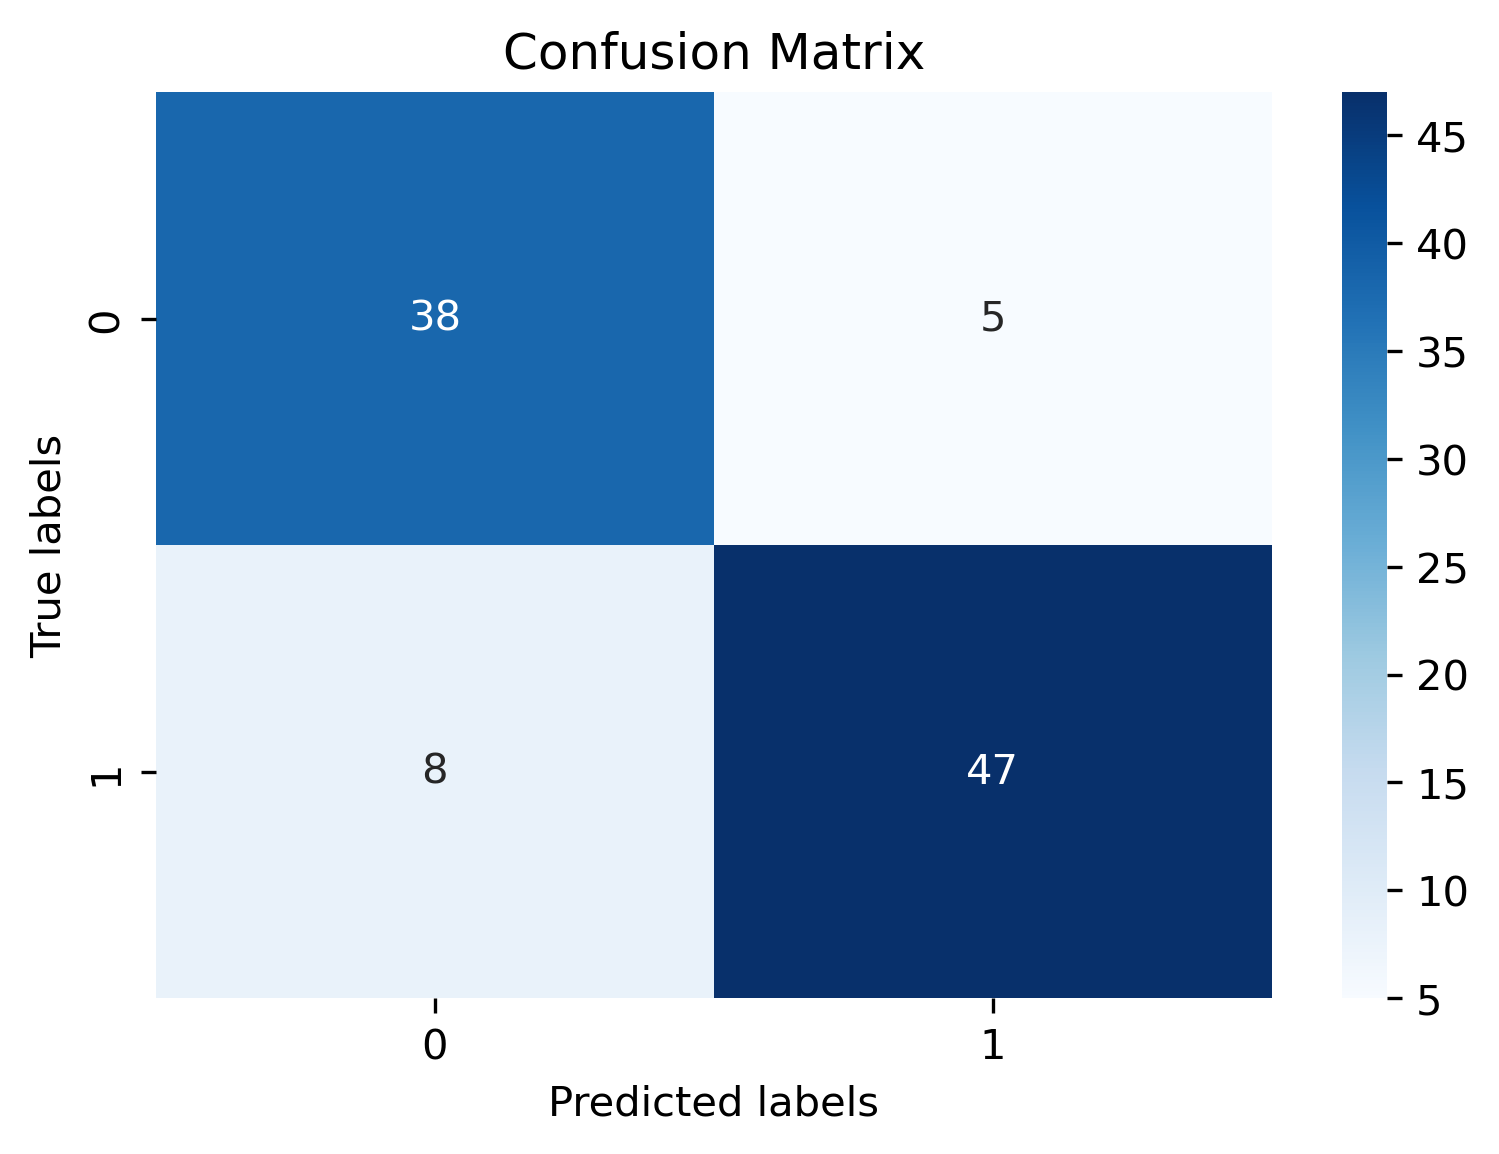

In [16]:
confusion_mat = confusion_matrix(test_dataset.y, y_test_pred)
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [17]:
test_pred_list = []
for test_score in y_test_pred_proba:
    test_score = test_score[1]
    test_pred_list.append(test_score)

In [18]:
test_pred_array = np.array(test_pred_list)

In [19]:
test_AUC = roc_auc_score(test_dataset.y,test_pred_list)
test_ACC = accuracy_score(test_dataset.y,np.round(test_pred_array))
test_PRE = precision_score(test_dataset.y,np.round(test_pred_array))
test_REC = recall_score(test_dataset.y,np.round(test_pred_array))

# Finall result

In [20]:
performance_dataset = {
    'AUC':[val_AUC,test_AUC],
    'ACC':[val_ACC,test_ACC],
    'PRE':[val_PRE,test_PRE],
    'REC':[val_REC,test_REC]
}

In [21]:
performance = pd.DataFrame(performance_dataset,index=['val','test'])
performance

,AUC,ACC,PRE,REC
val,0.928342,0.869231,0.858554,0.883913
test,0.945032,0.846939,0.900000,0.818182
